In [1]:
plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

HsHis6_PEX5C_vs_HsPEX5C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT.csv"
F606C_vs_AtPEX5C_WT_1_hour = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate_map.csv"
Hs_His6_PEX5C_vs_HsPEX5C_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C platemap.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT platemap.csv"
F606C_vs_AtPEX5C_WT_1_hour_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour platemap.csv"

In [43]:
import csv
import re
import string
import math
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit
import ipywidgets as wg
import warnings
from plate_mapping import plate_mapping as pm

# define custom errors
class DataError(Exception):
    pass

class PlateSizeError(Exception):
    pass

class DataTypeError(Exception):
    pass

# define well plate dimensions
plate_dim = {96:(8, 12), 384:(16, 24)}

# define header names
pm.header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                }

class FA:
    """Class used for the analysis of fluorescence anisotropy data.
    
    :param data_dict: A dictionary contaning data frames with pre-processed data and metadata
    :type data_dict: dict
    :param g_factor: G-factor
    :type g_factor: float 
    :param plate_map: dataframe from a plate map csv file that defines each and every well
    :type plate_map: pandas dataframe
    """
    
    def __init__(self, data_dict, g_factor, plate_map):
        self.data_dict = data_dict
        self.g_factor = g_factor
        self.plate_map = plate_map
        
        frames = []   # create list of all p and s data frames

        for repeat in self.data_dict.values():   
            metadata, data = repeat.values()
            p_channel, s_channel = data.values()
            frames.append(p_channel)
            frames.append(s_channel)
    
        new = pd.concat(frames, axis=1)   # join all p and s data frames into one df to run some stats
        nan = new.size - new.describe().loc['count'].sum()   # find number of 'nan' cells
        
        print("Data has been uploaded!\n")
        print(f"Value of g-factor: {self.g_factor} \nNumber of repeats: {len(self.data_dict)} \nOverall number of empty cells is {int(nan)} in {len(frames)} data frames.")
              
              
    @classmethod
    def read_in_envision(cls, data_csv, platemap_csv, data_type='plate', size=384):
        """Returns a dictionary of data frames, g-factor and platemap needed to construct the class object. 
        
        :param data_csv: File path of the raw data file in .csv format
        :type data_csv: str
        :param platemap_csv: File path of the platemap file in .csv format
        :type platemap_csv: str
        :param data_type: Format in which the raw data was exported (plate or list), defaults to plate
        :type data_type: str
        :param size: Size of the well plate (384 or 96), defaults to 384
        :type size: int
        :return: A dictionary contaning data frames with pre-processed data, g-factor, pandas data frame containing platemap
        :rtype: dict, float, pandas data frame """
        
        # ensure the plate size is either 384 or 96
        if size not in plate_dim:
            raise PlateSizeError('Invalid size of the well plate, should be 384 or 96.')
        
        # try to read in data in plate format
        if data_type == 'plate':
            try:
                data_dict, g_factor = FA._read_in_plate(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError, ValueError):
                raise DataError(f"Error occured during data read in. Check your file contains data in the 'plate' format and plate size is {size}.")
        
        # try to read in data in list format
        if data_type == 'list':
            try:
                data_dict, g_factor = FA._read_in_list(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError):
                raise DataError("Error occured during data read in. Check your file contains data in the 'list' format.")
        
        else:
            raise DataTypeError(f"'{data_type}' is not one of the two valid data types: plate or list.")
    

                
    def _read_in_plate(csv_file, size):
        """Reads the raw data file and finds the information needed to extract data. Passes those parameters to pre_process_plate function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor 
        :rtype: tuple """
        
        with open(csv_file) as file:
            all_data_lines = list(csv.reader(file, delimiter=','))   # read the csv file and cast it into a list containing all lines

        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [])   # list containing indices of all blank rows
        if blank_indexes == []:
            blank_indexes = list(index for index, item in enumerate(all_data_lines) if set(item) == {''})
        blanks = np.array(blank_indexes)   # convert the list of blank indices to a numpy array
        read_in_info = []   # list to store the tuples with parameters needed for pandas to read in the csv file

        for index, item in enumerate(all_data_lines):   # iterate over all lines in the csv file
            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) == None and re.findall(r"Formula", all_data_lines[index+1][10]) != ['Formula']:
                skiprows = index + 9   # Set the skiprows parameter for raw data table
                skiprows_meta = index + 1   # Set the skiprows parameter for metadata table
                end_of_data = blanks[blanks > skiprows].min()   # Calculate the end of data table by finding the smallest blank index after the beginning of data table
                read_in_info.append((skiprows, end_of_data - skiprows + 1, skiprows_meta))   # add the skiprows, caculated number of data lines and skiprows for metadata parameters to the list as a tuple
                data_format = 'plate1'

            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) != None:
                skiprows = index + 10
                skiprows_meta = index + 1
                end_of_data = blanks[blanks > skiprows].min()
                read_in_info.append((skiprows, end_of_data - skiprows - 1, skiprows_meta))
                data_format = 'plate2'

            if item != [] and len(item) > 1 and re.fullmatch(r"G-factor", item[0]):
                g_factor = float(item[4])   
        
        return FA._pre_process_plate(csv_file, read_in_info, data_format, size), g_factor

    
    def _pre_process_plate(csv_file, read_in_info, data_format, size):    
        """Extracts the data and metadata from the csv file, processes it and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param read_in_info: Tuples with read in parameters for each channel.
        :type read_in_info: list
        :param data_format: Plate type (plate1 or plate2)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata 
        :rtype: dict """ 
        
        data_frames = {}   # dictionary to store data frames
        counter = 1   # counter incremented by 0.5 to enable alternating labelling of data frames as 'p' or 's'

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, item in enumerate(read_in_info):   # iterate over all tuples in the list, each tuple contains skiprows, nrows and skiprows_meta for one channel 

            if data_format == 'plate1':   # raw data table does not have row and column names so 'names' parameter passed to omit the last column
                raw_data = pd.read_csv(csv_file, sep=',', names=col_numbers, index_col=False, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')

            if data_format == 'plate2':   # raw data table has row and column names, so index_col=0 to set the first column as row labels
                raw_data = pd.read_csv(csv_file, sep=',', index_col=0, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')
                if len(raw_data.columns) in [13, 25]:    
                    raw_data.drop(raw_data.columns[-1], axis=1, inplace=True)    # delete the last column because it is empty

            # generate df for metadata (number of rows of metadata table is always 1) and convert measurement time into datetime object   
            metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=item[2], nrows=1, encoding='utf-8').astype({'Measurement date': 'datetime64[ns]'})
            # convert and reshape data frame into 1D array
            data_as_array = np.reshape(raw_data.to_numpy(), (int(size), 1)) 

            if counter % 1 == 0: 
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p'])   # generate new 384 (or 96) by 1 data frame with p channel data
                data_frames[f'repeat_{int(counter)}'] = {'metadata':metadata, 'data': {'p': new_data, 's':''}}   # add p channel data and metadata dfs to dictionary

            if counter % 1 != 0:
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['s'])   # generate new 384 (or 96) by 1 data frame with s channel data
                data_frames[f'repeat_{int(counter-0.5)}']['data']['s'] = new_data   # add s channel data to dictionary

            counter = counter + 0.5
        
        return data_frames


    def _read_in_list(csv_file, size):
        """Reads the raw data file and extracts the data and metadata. Passes the raw data to pre_process_list function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor
        :rtype: tuple """

        with open(csv_file) as file:  
            all_data_lines = list(csv.reader(file, delimiter=',')) # read the csv file and cast it into a list containing all lines
 
        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indexes of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indexes to a numpy array
        
        # iterate over all lines to find beggining of the data table ('skiprows') and determine the format of data  (list A, B, or C)
        for index, item in enumerate(all_data_lines):   
            if item != [] and len(item) == 1 and re.findall(r"Plate information", item[0]) == ["Plate information"]:
                skiprows_meta = index + 1
                end_of_metadata = blanks[blanks > skiprows_meta].min()   # find the end of metadata by finding the smallest blank index after the beginning of metadata
                
            if item != [] and len(item) >= 2 and re.findall(r"PlateNumber", item[0]) == ['PlateNumber'] and re.findall(r"PlateRepeat", item[1]) == ['PlateRepeat']:   # find line number with the beggining of the data
                skiprows = index - 1
                data_format = 'listA'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate'] and re.findall(r"Barcode", item[1]) == ['Barcode']:   # find line number with the beggining of the data
                skiprows = index
                data_format = 'listB'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate']  and re.findall(r"Well", item[1]) == ['Well']:
                skiprows = index
                data_format = 'listC'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and re.fullmatch(r"G-factor", item[0]):   # find the g factor
                g_factor = float(item[4])

        nrows = end_of_data - skiprows - 1   # calculate the length of data table
        nrows_meta = end_of_metadata - skiprows_meta - 1   # calucalte the length of metadata table (number of rows depends on the number of repeats)

        raw_data = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows, nrows=nrows, encoding='utf-8')
        raw_metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows_meta, nrows=nrows_meta, encoding='utf-8')

        return FA._pre_process_list(raw_data, raw_metadata, data_format, size), g_factor


    def _pre_process_list(raw_data, raw_metadata, data_format, size):
        """Extracts the data and metadata for each channel and repeat from the raw data and raw metadata 
        and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param raw_data: Data frame containing raw data
        :type raw_data: pandas data frame
        :param raw_metadata: Data frame containing raw metadata
        :type raw_metadata: pandas data frame
        :param data_format: Type of list (listA, listB, or listC)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata
        :rtype: dict"""

        # remove the '0' from middle position of well numbers (A01 -> A1), done by reassigning the 'Well' column to a Series containing modified well numbers
        raw_data['Well'] = raw_data['Well'].apply(lambda x: x[0] + x[2] if x[1] == '0' else x)
        
        data_frames = {}   # dictionary to store data frames
        repeats = list(raw_metadata['Repeat'].to_numpy())   # generate a list with repeats based on the metadata table, e.g. for 3 repeats -> [1,2,3]

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, repeat in enumerate(repeats):   # iterate over the number of repeats
            if data_format == 'listA':
                groupped_data = raw_data.groupby(raw_data.PlateRepeat).get_group(repeat)   # group and extract the data by the plate repeat column, i.e. in each iteration get data only for the current repeat 

                p_groupped = groupped_data.iloc[::3, :]   # extract data only for the p channel, i.e. each third row starting from the first row
                s_groupped = groupped_data.iloc[1::3, :]   # extract data only for the s channel, i.e. each third row starting from the second row

                p_raw_data = p_groupped[['Well', 'Signal']]   # extract only the two relevant columns
                s_raw_data = s_groupped[['Well', 'Signal']]   # for each channel

            if data_format in ['listB', 'listC']: 
                # the column naming is different for the first repeat ('Signal'), then it's 'Signal.1', 'Signal.2', etc.
                if repeat == 1: 
                    p_raw_data = raw_data[['Well', 'Signal']]   
                    s_raw_data = raw_data[['Well', f'Signal.{repeat}']]
                else:
                    p_raw_data = raw_data[['Well', f'Signal.{repeat + index - 1}']]   # the column cotntaining data to be extracted is calculated in each iteration
                    s_raw_data = raw_data[['Well', f'Signal.{repeat + index}']]
            
            # create an empty df with no columns and indexes matching the plate size
            indexes = pd.DataFrame(well_ids, columns=['Wells'])
            empty_frame = indexes.set_index('Wells')
            
            p_raw_data.set_index('Well', inplace=True)   # set the row indexes as the well numbers
            p_raw_data.set_axis(['p'], axis=1, inplace=True)   # rename the 'Signal' column to 'p'
            p_data = empty_frame.join(p_raw_data)   # join the raw data df to an empty frame based on the indexes, assigns 'NaN' to indexes not present in the raw data table
            
            s_raw_data.set_index('Well', inplace=True) 
            s_raw_data.set_axis(['s'], axis=1, inplace=True)
            s_data = empty_frame.join(s_raw_data)
    
            metadata = raw_metadata.iloc[[repeat-1]].astype({'Measurement date': 'datetime64[ns]'})   # extract the row with metadata relevant for each repeat and covert date and time into a datetime object
            data_frames[f'repeat_{repeat}'] = {'metadata': metadata, 'data': {'p': p_data, 's': s_data}}   # add data frames to the dictionary

        return data_frames
    
    
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='Paired', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        The label and colour for each well can be customised to be a variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s anisotropy value from a specified repeat passed as a tuple of strings, for example ('repeat_2', 'p') for p data from repeat 2
        
        :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), default = 'Type'
        :type colorby: str or tuple
        :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Protein', ('repeat_1', 's'), default = 'Type'
        :type labelby: str or tuple
        :param title: Sets the title of the figure, default none
        :type title: str
        :param cmap: Sets the colormap for the color-coding, default = 'Paired'
        :type cmap: str
        :param dpi: Size of the figure, default = 250
        :type dpi: int
        :param export: If 'True' a .png file of the figure is saved, default = False
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        size = plate_map.shape[0]
        scinot = False
        str_len = None
        
        if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[labelby[0]]['data'][labelby[1]])   # data frame containing p or s values from specified repeat is added to the platemap
            labelby = labelby[1]
        if type(colorby) == tuple:   # option for colouring by the p or s anisotropy values
            plate_map = plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            colorby = colorby[1]
            
        if labelby in ['Protein Concentration', 'Tracer Concentration', 'Competitor Concentration', 'p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw' , 'i_corrected']:
            if sum((plate_map[labelby] > 1000) | (plate_map[labelby] < 0)) > 0:   # display in sci notation if the number is greater than 1000 or less than 0
                scinot = True
                str_len = 8
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, dpi=dpi, scinot=scinot, str_len=str_len)
    
    
    def invalidate(self, valid=False, **kwargs):
        """Invalidates wells, columns and/or rows. Any of the following arguments, or their combination, can be passed: wells, rows, columns. 
        For example to invalidate well A1, rows C and D and columns 7 and 8 execute the following: invalidate(wells='A1', rows=['C','D'], columns=[7,8]).
        To validate previously invalidated wells, rows and/or columns, pass the additional 'valid' argument as True.
    
        :param valid: Sets the stipulated row or rows 'True' or 'False', default = False
        :type valid: bool
        :param wells: Wells to be invalidated passed as a string or a list of strings
        :type wells: str or list
        :param rows: Rows to be invalidated passed as a string or a list of strings
        :type rows: str or list
        :param columns: Columns to be invalidated passed as an integer or a list of integers
        :type columns: int or list
        """
        # execute the corresponding invalidate functon from the platemapping package
        if 'wells' in kwargs:
            pm.invalidate_wells(platemap=self.plate_map, wells=kwargs['wells'], valid=valid)
        if 'rows' in kwargs:
            rows = tuple(kwargs['rows']) # convert the rows to tuple because invalidate_rows cannot take in a list
            pm.invalidate_rows(platemap=self.plate_map, rows=rows, valid=valid)
        if 'columns' in kwargs:
            pm.invalidate_cols(platemap=self.plate_map, cols=kwargs['columns'], valid=valid)
        if len(kwargs) == 0:   # return error if neither of the keyword arguments is passed
            raise TypeError('No arguments were passed. Specify the wells, rows and/or columns to be invalidated!')
            
    def background_correct(self):
        """Calculate background corrected values for p and s channel in all repeats.
        
        Cacluclated by subtracting the mean value of blank p or s for a given concentration from each value of compound p or s for that concentration."""
        
        for key, value in self.data_dict.items(): 
            metadata, data = value.values()   
            ##### raise error if background correction has already been performed
            #if 'p_corrected' or 's_corrected' in data:
                #raise AttributeError ('The background correction has already been performed.')

            # create joined dfs of platemap and p or s
            p_df = self.plate_map.join(data['p'])  
            s_df = self.plate_map.join(data['s'])
            # calculate p and s corrected and add them to data dictionary
            self.data_dict[key]['data']['p_corrected'] = FA._backg_correct(p_df, 'p_corrected')
            self.data_dict[key]['data']['s_corrected'] = FA._backg_correct(s_df, 's_corrected')
            
            print('Background correction has been successfully performed!')
            
    def _backg_correct(df, col_name):
        """Calculate background corrected p or s.
        
        :param df: Joined platemap and raw p or s values 
        :type df: pandas df
        :param col_name: Name of the column with background corrected values
        :type col_name: str
        :return: Data frame with background corrected p or s values (depending on col_name parameter)
        :rtype: pandas df"""
        
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # 'p' or 's' values are replaced with NaN if the well is invalidated
        no_index = df.reset_index()   # move the index to df column

        mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created
        
        mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean'

        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with blank wells
        
        joined = reindexed.join(blank, on=['Protein Name', 'Protein Concentration'])
        joined[col_name] = joined[joined.columns[-2]] - joined['Mean']   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2]).rename_axis(None)   # set index to 'well id' and move multiindex to df columns
        
        return jindexed[[col_name]]
    
    
    def calculate_r_i(self, correct=True, plot_i=True, thr=80):
        """Calculates anisotropy and fluorescence intensity.
        The fluorescence intensity (I) and anisotropy (r) are calculated using the follwing formulas: I = s + (2*g*p), r = (s - (g*p)) / I and stored 
        in data_dict as i_raw and r_raw (calculated using the uncorrected p and s channel values) 
        and i_corrected and r_corrected (if calculated using the background corrected p and s channel values, as well).
        
        :param correct: Calculate the anisotropy and intensity using the background corrected values of p and s, as well, default=True
        :type correct: bool
        :param plot_i:
        :type plot_i: bool
        :param th: 
        :type th: int"""
        
        FA.th = thr   # assign the threshold value to the class variable so that it can be accessed outside of this function
    
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            # calculate raw intensity and anisotropy and add them to data dictionary
            i, r = FA._calc_r_I(data['p'], data['s'], self.g_factor, 'raw')
            self.data_dict[key]['data']['i_raw'] = i   
            self.data_dict[key]['data']['r_raw'] = r   
            
            if correct:   # calculate intensity and anisotropy using background corrected values of p and s
                if 'p_corrected' and 's_corrected' not in data:   # check if background subtraction has been done
                    raise AttributeError('The corrected anisotropy and intensity can only be calculated after background correction of the raw p and s channel data.')
                
                i_c, r_c = FA._calc_r_I(data['p_corrected'], data['s_corrected'], self.g_factor, 'corrected')
                self.data_dict[key]['data']['i_corrected'] = i_c   
                self.data_dict[key]['data']['r_corrected'] = r_c    
                
                self.data_dict[key]['data']['i_percent'] = FA._calc_I_percent(i, i_c, self.plate_map)
        
        print('The fluorescence intensity and anisotropy have been successfully calculated!\n')
        
        if plot_i:   # plot the percentage intensity againt the well ids for all repeats
            FA._plot_i_percent(self.data_dict)

        
    def _calc_r_I(p, s, g, col_suffix):
        """Calculates either anisotropy or intensity and labels the resulting dfs according to the parameters passed
        
        :param p: Pandas data frame with p channel data (can be both raw and background corrected)
        :type p: pandas df 
        :param s: Pandas data frame with s channel data (can be both raw and background corrected)
        :type s: pandas df
        :param g: G-factor
        :type g: float
        :param col_suffix: Suffix to add to column name of the resulting intensity or anisotropy data frame, e.g. 'raw', 'corrected'
        :type col_suffix: str
        :return: Data frames with calculated anisotropy and intensity values
        :rtype: pandas df"""
        
        p_rn = p.rename(columns={p.columns[0]: s.columns[0]})   # rename the col name in p data frame so that both p and s dfs have the same col names to enable calculation on dfs
        i = s + (2 * g * p_rn)       # calculate intensity
        r = (s - (g * p_rn)) / i     # and anisotropy
        i_rn = i.rename(columns={i.columns[0]: 'i_'+col_suffix})   # rename the col name using the column suffix argument
        r_rn = r.rename(columns={r.columns[0]: 'r_'+col_suffix})           
            
        return i_rn, r_rn  
    
    
    def _calc_I_percent(ir, ic, platemap):
        """Calculate the percentage intensity of blank wells compared to non-blank wells.
        
        :param ir: Data frame with corrected intensity 
        :type ir: pandas df
        :param ic: Data frame with raw intensity
        :type ic: pandas df
        :param platemap: Platemap
        :type platemap: pandas df
        :return: df containing only the non-blank and non-empty columns
        :rtype: pandas df"""
        
        ir_rn = ir.rename(columns={ir.columns[0]:ic.columns[0]})   # rename the col name in raw intensity df so that it's the same as in corrected intensity df
        percent = (ir_rn - ic)/ir_rn * 100   
        percent.rename(columns={'i_corrected':'i_percent'}, inplace=True)
        joined = platemap.join(percent)   # join the percent data to platemap
        subset = joined[(joined['Type'] != 'blank') & (joined['Type'] != 'empty')]   # subset only the non-blank and non-empty columns
        
        return subset
    
                 
    def _plot_i_percent(data_d):
        """Plot the percentage intensity against the well ids with a horizotanl threshold bar and preint the list of wells above the threshold for all repeats
        
        :param data_d: Dictionary with data for all repeats
        :type data_d: dict """
        
        st = ''   # empty string to which lists of wells to be printed are appended after checking data from each repeat
        fig = plt.figure(figsize=(8*int((len(data_d) + 2 - abs(len(data_d) - 2))/2), 4*int( math.ceil((len(data_d))/2)) ), tight_layout=True)   # plot a figure with variable size depending on the number subplots (i.e. repeats)
        fig.suptitle('The percentage intensity of a non-blank well was plotted for all repeats', fontsize=14)   # add the figure title
        
        for key, value in data_d.items():   # iterate over all repeats
            metadata, data = value.values()
            df_per = data['i_percent']
            
            plt.subplot(int( math.ceil((len(data_d))/2) ), int( (len(data_d) + 2 - abs(len(data_d) - 2))/2 ), int(key[-1]))
            plt.bar(df_per.index, df_per['i_percent'])   # plot a bar plot with intensity percentage data 
            plt.axhline(FA.th, color='red')   # plot a horizontal line representing the threshold on the bar plot
            ax = plt.gca()   # get the axis object
            ax.set_ylabel('')
            ax.set_xlabel('wells')
            ax.set_title(key)
            ax.yaxis.set_major_formatter(mtick.PercentFormatter())   # set formatting of the y axis as percentage
            xlabels = [i if len(i) == 2 and i[1] == '1' else '' for i in list(df_per.index)]   # create a list of xtics and xticklabels consiting only of the first wells from a each row
            ax.set_xticks(xlabels)
            ax.set_xticklabels(xlabels)
        
            wells = list(df_per[df_per['i_percent'] > FA.th].index)   # get a list of well ids above the threshold for this repeat
            if wells != []:   # append wells above the threshold and the repective repeat number to the string with appropriate formatting
                st = st + f'\t{key}: {str(wells)}\n'
        
        plt.show()   # ensure the figure is displayed before printing the summary message

        if st != '':   # display the summary of wells above the threshold
            print(f'In the following wells the percentage intensity value was above the {FA.th}% threshold:')
            print(st)
        else:
            print(f'None of the wells has the percentage intensity value above the {FA.th}% threshold.')
            
            
    def plot_i_percent(self):
        """This function only displays the results calculated by the calculate_r_i function and does not recalculate it."""
        return FA._plot_i_percent(self.data_dict)
    
    
    def calc_data_to_fit(self):
        """Calculates data required for fitting a curve to the plot of anisotropy (or intensity) against protein concentration.
        The following data is calcualted for both intensity and anisotropy for all repeats: mean, standard devition and standard error.
        Also, a data frame for storing fitting parametres is created.
        """
        for key, value in self.data_dict.items():
            metadata, data = value.values()
            
            r_mean_dict, r_fitparams = FA._fitting_data(data['r_corrected'], self.plate_map)   
            data['r_mean'] = r_mean_dict   # create dictionary 'r_mean' with mean anisotropy data frames for each protein-tracer pair
            data['r_params'] = r_fitparams   # create empty df for storing the fitting parameters
            
            i_mean_dict, i_fitparams = FA._fitting_data(data['i_corrected'], self.plate_map)
            data['i_mean'] = i_mean_dict   # create dictionary 'i_mean' with mean intensity data frames for each protein-tracer pair
            data['i_params'] = i_fitparams   # create empty df for storing the fitting parameters
    
    
    def _fitting_data(df, plate_map):
        """Calculates mean anisotropy for each protein concentration value, its standard deviation and standard error.
        Creates an empty data frame for storing the fitting parameters for each repeat and sets the lambda value as 1.
        
        :param df: Data frame with anisotropy or intensity values
        :type df: pandas df
        :param plate_map: Plate map data frame
        :type plate_map: pandas df
        :return: A dictionary with data frames for each unique protein-tracer pair and data frame for storing the fitting parameter
        :rtype: tuple (dict, pandas df)"""
        
        join = plate_map.join(df)   # join anisotropy values to platemap
        subset = join[(join['Type'] != 'blank') & (join['Type'] != 'empty')]   # take only non-blank and non-empty cells
        noidx = subset.reset_index()
        group = noidx.groupby(['Protein Concentration', 'Protein Name', 'Tracer Name'])
        mean = group.mean()   
        std = group.std()     
        sem = group.sem()    
        meanr = mean.rename(columns={mean.columns[-1]: 'mean'})
        stdr = std.rename(columns={std.columns[-1]: 'std'}).drop('Valid', axis=1)   # also drop the 'Valid' column
        semr = sem.rename(columns={sem.columns[-1]: 'sem'}).drop('Valid', axis=1)   # also drop the 'Valid' column
        merge = pd.concat([meanr, stdr, semr], axis=1)
        tosplit = merge.reset_index()   # remove multiindex
        split = dict(tuple(tosplit.groupby(['Protein Name', 'Tracer Name'])))   # split df based on multiindex so that a new df is created for each unique combination of protein and tracer
        
        keys = list(split.keys())   # create a list of protein-tracer tuples
        idx = pd.MultiIndex.from_tuples(keys)   # create a multiindex based on the list of tuples 
        new_df = pd.DataFrame(index=idx, columns=[f'{df.columns[0][0]}min',f'{df.columns[0][0]}min error', 
            f'{df.columns[0][0]}max', f'{df.columns[0][0]}max error', 'EC50', 'EC50 error', 'hill', 'hill error', 'lambda'])   # create new df for storing the fitting parameters
        new_df['lambda'] = 1   # set the default lambda value as 1
        
        return split, new_df

    
    def _r_func(pc, rmin, rmax, EC50, hill):
        """Function for fitting a curve to the plot of anisotropy (or intensity) against protein concentration, 
        where pc is protein concentration, rmin is the lower asymptote, rmax is the upper asymptote, 
        EC50 is midpoint of transition (pc at point of inflection), hill is the slope
        """
        return (rmin - rmax) / (1 + (pc/EC50)**hill) + rmax
    
    
    def _init_params(df):
        """Estimates initial parameters for the r_func that are passed to the curve fitting function
        
        :param df: Data frame containing mean values of anisotropy or intensity
        :type df: pandas df
        :return: List with estiamted parameters of min, max and EC50, hill is assumed to be 1
        :rtype: list
        """
        rmin = df['mean'].min()
        rmax = df['mean'].max()
        mid = (rmax + rmin) / 2
        mid_idx = df['mean'].sub(mid).abs().argmin()
        EC50 = df.iloc[mid_idx]['Protein Concentration']
        init_param = [rmin, rmax, EC50, 1]
        return init_param
    
    def _logistic_fit(df, sig=None, **kwargs):
        """Fits a curve to the plot of anisotropy (or intensity) against protein concentration
        
        :param df: Data frame containing mean values of anisotropy (or intensity)
        :type df: pandas df
        :param **kwargs: Keyword arguments that can be passed into the scipy curve_fit function
        :return: A list of fitting parameters along with their error in proper order so that it can be added to the fitting params data frame
        :rtype: list
        """
        drop = df[df['Protein Concentration'] != 0].dropna()   # exclude the protein concentration = 0 point from data fitting
        if sig != None:
            sig = drop[sig]
        popt, pcov = curve_fit(FA._r_func, drop['Protein Concentration'], drop['mean'], sigma=sig, **kwargs)
        perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params
        all_params = np.insert(popt, obj=[1,2,3,4], values=perr)   # insert the errors after the respective fitting parameter value
        
        return list(all_params) 
    
    
    def logistic_fit_all(self, sig=None, **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration for all repeats.
        Returns the fitting parameters with associated errors that are stored in the fitting paramters data frame in data dict.
        The calc_data_to_fit function must be executed prior to data fitting.
        
        :params **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        errors = []   # list for storing the details of errors due to failed fitting
        
        for rep, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            keys = list(data['r_mean'].keys())   # create a list of unique protein-tracer pairs
            
            for key in keys:   # iterate over all protein-tracer pairs
                try:   # try fitting the curve
                    r_mean = data['r_mean'][key]   # extract the df with r mean for a given protein-tracer pair
                    params_r = FA._logistic_fit(r_mean, p0=FA._init_params(r_mean), sig=sig, **kwargs)   # fit the data to logistic curve using the initial parameteers
                    data['r_params'].loc[key, ['rmin','rmin error','rmax', 'rmax error', 'EC50', 'EC50 error', 'hill', 'hill error']] = params_r   # add the fitting parameters to the respective df
                except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed to to the next protein-tracer pair
                    r_errorinfo = (rep, 'r', key, e)
                    errors.append(r_errorinfo)
                
                try:   # try fitting the curve
                    i_mean = data['i_mean'][key]
                    params_i = FA._logistic_fit(i_mean, p0=FA._init_params(i_mean), sig=sig, **kwargs)
                    data['i_params'].loc[key, ['imin','imin error','imax', 'imax error', 'EC50', 'EC50 error', 'hill', 'hill error']] = params_i
                except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed to to the next protein-tracer pair
                    i_errorinfo = (rep, 'i', key, e)
                    errors.append(i_errorinfo)
        
        if errors != []:
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nUse the 'logistic_fit_pair' function to adjust the initial guess for the parameters or pass other arguments to the fitting function.", RuntimeWarning)
            
    def logistic_fit_pair(self, rep, var, pair, sig=None, **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration only for the specified protein-tracer pair
        Returns the fitting parameters with associated errors, the fitting parameters already present for this protein-tracer pair will be overwritten.
        
        :param rep: Repeat number, e.g. 'repeat_1'
        :type rep: str
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer pair for which the fitting is to be performed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments that can be passed to the scipy curve_fit function
        """
        df = self.data_dict[rep]['data'][f'{var}_mean'][pair]   # extract the df with data to be fitted
        if 'p0' not in kwargs:   # if the user did not pass their intial parameter guess, use the ones from init_params function
            par = FA._logistic_fit(df, p0=FA._init_params(df), sig=sig, **kwargs)
        else:
            par = FA._logistic_fit(df, sig=sig, **kwargs)
            
        self.data_dict[rep]['data'][f'{var}_params'].loc[pair, [f'{var}min',f'{var}min error', f'{var}max', f'{var}max error', 'EC50', 'EC50 error', 'hill', 'hill error']] = par
        
        
    def set_fitparams(self, rep, var, pair, **kwargs):
        """Allows to set a value of any parameter in the fitting params data frame for specific protein-tracer pair and repeat
        
        :param rep: Repeat number, e.g. 'repeat_1'
        :type rep: str
        :param var: A one character string representing anisotropy ('r') or intensity ('i')
        :type var: str
        :param pair: A tuple of two strings representing the protein and tracer names for which the parameters will be changed, e.g. ('proteinA', 'tarcerB')
        :type pair: tuple
        :param **kwargs: Keyword arguments represeting the parameter and its value, e.g. lambda=1.5, rmin=0.30
        """
        if var in ['r', 'i'] and f'{var}_params' not in self.data_dict[rep]['data']:   # check whether fitting parameters data frame exists
            raise AttributeError('The table with fitting parameters has not been created. Run the calc_data_to_fit function first.')
            
        for key, value in kwargs.items():   # iterate over the kwargs dictionary
            self.data_dict[rep]['data'][f'{var}_params'].loc[pair, key] = value   # overwrite the parameters in fitting params df with all params passed as keyword arguments
            
            
    def calc_lambda(self, approve=True):
        """Calculates lambda value for each protein-traceer pair for all repeats. 

        If 'approve=True', a list with calcualted lambda values with checkboxes will be displayed. To approve the proposed value 
        tick the selected checkboxes and click 'Update' button. If 'approve=False', all of the calculated values will be saved and 
        the list with checkboxes will not be displayed. You can still amend any values in the fitting parameters data frame using the 'set_fitparams function.

        :param approve: If True a list of checkboxes will be displayed to choose the lambda values that will be saved, default True
        :type approve: bool
        """
        lambdas = []   # list of tuples for generation of widgets
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            df = data['i_params']
            new_df = df.copy() 
            new_df['lambda'] = new_df['imax']/new_df['imin']   # calculate the lambda value in a copied data frame

            if approve == False:   # if the user does not want to manually approve the proposed values
                df['lambda'] = new_df['lambda']   # amend the fitting parameters df with calcualted lambda values
                print('The lambda values were calculated and saved.')
            else:
                index = list(new_df.index)   # list of tuples with protein-tracer names
                for item in index:
                    rating = 100
                    tp = (key, item, rating, new_df.loc[item, "lambda"])   # tuples conataining repeat no., calculated lambda, and protein-tracer names
                    lambdas.append(tp)
        
        final_fit=pd.DataFrame(index=df.index, columns=['rmin', 'rmax', 'lambda'])
        final_fit["lambda"] = 1
        
        FA.final_fit = final_fit
        if approve == True:

            reps = []   # list of text widgets with repeat numbres
            proteins = []   # list of text widgets with protein names
            tracers = []   # list of text widgets with tracer names
            scores = []
            checkboxes = []   # list of checkbox widgets
            
            for i in lambdas:   # iterate over each tuple and create set of four widgets for it 
                cbox = wg.Checkbox(value=False, description=f"{i[3]}")   # create checkbox widget
                checkboxes.append(cbox)
                protein = wg.HTML(f"{i[1][0]}")   # create text widget with protein name
                proteins.append(protein)
                tracer=wg.HTML(f"{i[1][1]}")   # create text widget with tracer name 
                tracers.append(tracer)
                rep=wg.HTML(f"{i[0]}")   # create text widget with repeat number
                reps.append(rep)
                score=wg.HTML(f"Score: {i[2]}")   # create text widget with tracer name 
                scores.append(score)
                
            v_checkbox = wg.VBox(children=checkboxes)   # group all checkbox widgets into a vertical list layout
            v_proteins = wg.VBox(children=proteins)   # group all protein name widgets into a vertical list layout
            v_tracers = wg.VBox(children=tracers)   # group all tracer name widgets into a vertical list layout
            v_reps = wg.VBox(children=reps)   # group all repeat number widgets into a vertical list layout
            v_scores = wg.VBox(children=scores)
            
            hbox = wg.HBox([v_reps, v_proteins, v_tracers, v_scores, v_checkbox])   # arrange the four vertical boxes into one widget box   # add 'v_reps'
            button = wg.Button(description='Save')   # create a button for saving the selected lambda values
            print("""Choose the lambda values that will be saved for each protein-tracer pair. \nIf you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.\n""")
            display(hbox, button)   # display the box with widgets and update button

            def btn_eventhandler(obj):   # delete the lambda column in the previous data frame???
                """Function that is executed when the 'Save' button is clicked. It checks which checkboxes were ticked and 
                updates the fitting parameter df with the calcualted lambda values. """
        
                added = []    
                for i in range(0, len(checkboxes)):   # iterate over each checkbox widget
                    if checkboxes[i].value == True:   # if the checkbox was ticked, the widget's 'value' attribute is True
                        index = (proteins[i].value, tracers[i].value)   # get the tuple with protein-tracer names 
                        #self.data_dict[reps[i].value]['data']['i_params'].loc[index, "lambda"] = float(checkboxes[i].description)   # update the fitting params df with new lambda value
                        if index not in added:
                            FA.final_fit.loc[index, "lambda"] = float(checkboxes[i].description)
                            FA.final_fit.loc[index, ['rmin', 'rmax']] = self.data_dict[reps[i].value]['data']['r_params'].loc[index, ["rmin", "rmax"]]
                            added.append(index)
                        
                print('The selected lambda values were saved.')
                
            button.on_click(btn_eventhandler)   # link the button event handler function with actual clicking of the button using 'on_click' function
            
    def plot_ani_all(self, err='std'):   
        "Create figures for all repeats"
        for key, value in self.data_dict.items():
            metadata, data = value.values()
            keys = list(data['r_mean'].keys())
            fig, axs = plt.subplots(len(keys), 2, figsize=(2*6.4, len(keys)*4.8), tight_layout=True)   # grid has two columns and variable number of rows, figsize automatically scales up
            fig.suptitle(key, fontsize=18)

            for idx, item in enumerate(keys):   # for each portein-tracer pair plot two graphs: anisotropy and intensity
                r_data_df = data['r_mean'][item]
                i_data_df = data['i_mean'][item]
                FA._plot(data_df=r_data_df, params_df=data['r_params'], pt_pair=item, fig=fig, axs=axs[idx,0], err=err, var='r', rep=key, export=False, display=True, labels=True)
                FA._plot(data_df=i_data_df, params_df=data['i_params'], pt_pair=item, fig=fig, axs=axs[idx,1], err=err, var='i', rep=key, export=False, display=True, labels=True)
                
    def _plot(data_df, params_df, pt_pair, fig, axs, err, var, rep, export, display, labels, dpi=250):
        
        drop = data_df[data_df['Protein Concentration'] != 0].dropna()
        axs.errorbar(drop['Protein Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('symlog')
        axs.set_ylabel('Intensity')
        axs.set_xlabel(f'{pt_pair[0]} concentration (nM)')
        axs.plot(drop['Protein Concentration'], FA._r_func(drop['Protein Concentration'], 
            params_df.loc[pt_pair, f'{var}min'], params_df.loc[pt_pair, f'{var}max'], params_df.loc[pt_pair, 'EC50'], params_df.loc[pt_pair, 'hill']), color='blue')
        axs.legend(['logistic fitted curve'])
        
        if labels == True:
            axs.set_title(f'{rep}, Protein: {pt_pair[0]}, Tracer: {pt_pair[1]}')
            axs.legend(['logistic fitted curve'])
            text = f"{var}min=%.2f \u00B1 %.4f\n{var}max=%.2f \u00B1 %.4f\nEC50=%.0f \u00B1 %.0f\nhill=%.2f \u00B1 %.2f" % (params_df.loc[pt_pair, f'{var}min'], 
                params_df.loc[pt_pair, f'{var}min error'], params_df.loc[pt_pair, f'{var}max'], params_df.loc[pt_pair, f'{var}max error'], 
                params_df.loc[pt_pair, 'EC50'], params_df.loc[pt_pair, 'EC50 error'], params_df.loc[pt_pair, 'hill'], params_df.loc[pt_pair, 'hill error'])
            if var == 'r':
                text_coords = (0.02, 0.72)
            else:
                text_coords = (0.02, 0.03)
            axs.annotate(text, xy=text_coords, xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"))
            
        if export == True:   # save figures in the same directory as the notebook
            fig.savefig(f"{rep}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if type(export) == str:   # save figures in the user defined directory
            fig.savefig(f"{export}{rep}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if display == False:
            plt.close(fig)
                
    def export_ani_figs(self, err='std', export=True, dpi=250):
        "Saves figures for all repeats"
        
        for key, value in self.data_dict.items():
            metadata, data = value.values()
            pairs = list(data['r_mean'].keys())
                                
            for pt_pair in pairs:
                r_data_df = data['r_mean'][pt_pair]
                i_data_df = data['i_mean'][pt_pair]
                
                fig_r, ax_r = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
                FA._plot(data_df=r_data_df, params_df=data['r_params'], pt_pair=pt_pair, fig=fig_r, axs=ax_r, err=err, var='r', rep=key, export=export, display=False, labels=False, dpi=dpi)
                fig_i, ax_i = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
                FA._plot(data_df=i_data_df, params_df=data['i_params'], pt_pair=pt_pair, fig=fig_i, axs=ax_i, err=err, var='i', rep=key, export=export, display=False, labels=False, dpi=dpi)
        
    def plot_ani(self, rep, var, pair, err='std', export=False, labels=True, dpi=250):
        data_df = self.data_dict[rep]['data'][f'{var}_mean'][pair]
        params_df = self.data_dict[rep]['data'][f'{var}_params']
        fig, ax = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
        
        return FA._plot(data_df=data_df, params_df=params_df, pt_pair=pair, fig=fig, axs=ax, err=err, var=var, rep=rep, export=export, display=True, labels=labels, dpi=dpi)

In [44]:
my_data1 = FA.read_in_envision(data_csv=HsHis6_PEX5C_vs_HsPEX5C, platemap_csv=Hs_His6_PEX5C_vs_HsPEX5C_platemap, data_type='plate', size=384)

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.


In [45]:
my_data1.background_correct()
my_data1.calculate_r_i(thr=60, plot_i = False)
my_data1.calc_data_to_fit()
my_data1.logistic_fit_all()

Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



<ipython-input-43-8fb4bedb4051>:647: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params


In [8]:
my_data1.data_dict['repeat_1']['data']['r_params'].loc[('Hs-His6-PEX5C','Lissamine-YQSKL'), ['rmin', 'rmax']]

rmin    0.101713
rmax    0.238391
Name: (Hs-His6-PEX5C, Lissamine-YQSKL), dtype: object

In [49]:
my_data1.calc_lambda() 

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.



Button(description='Save', style=ButtonStyle())

In [50]:
my_data1.final_fit

,,rmin,rmax,lambda
Hs-His6-PEX5C,Lissamine-YQSKL,0.101713,0.238391,0.807355
HsPEX5C,Lissamine-YQSKL,0.100903,0.280979,0.320507


In [16]:
my_data1.export_ani_figs(export="C:\\Users\\Bartek\\Desktop\\", err='sem')

In [46]:
my_data1.logistic_fit_pair(rep='repeat_1', var='i', pair=('Hs-His6-PEX5C','Lissamine-YQSKL'), sig='std', p0=[500000, 300000, 1300, 2])

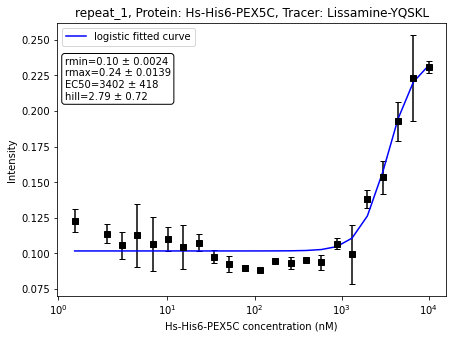

In [51]:
my_data1.plot_ani(rep='repeat_1', var='r', pair=('Hs-His6-PEX5C','Lissamine-YQSKL'))

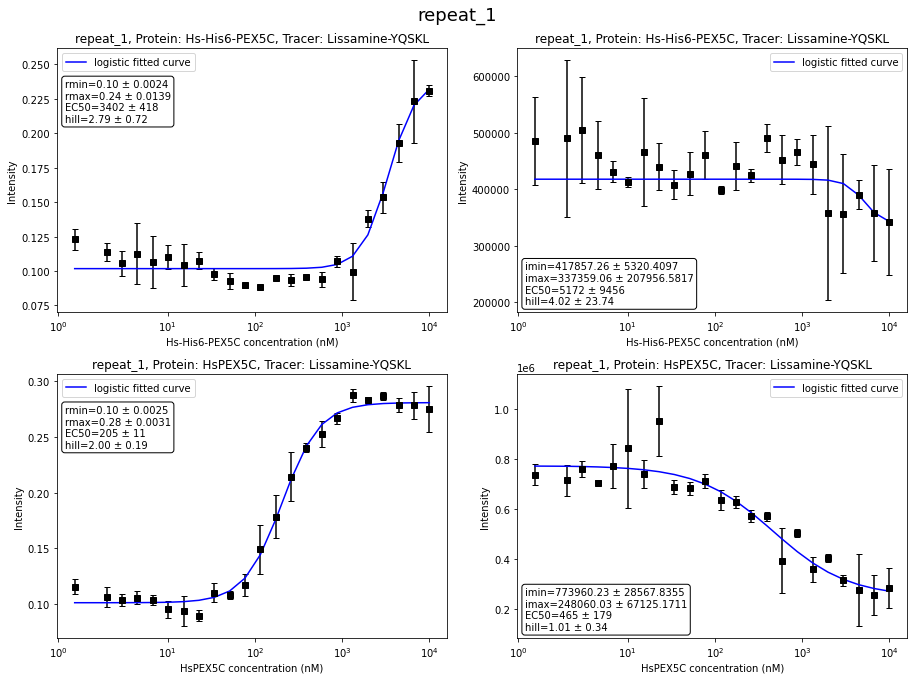

In [48]:
my_data1.plot_ani_all()

In [15]:
my_data1.plate_map

,Type,Contents,Protein Name,Protein Concentration,Tracer Name,Tracer Concentration,Competitor Name,Competitor Concentration,Concentration Units,Valid
A1,compound,NaN,Hs-His6-PEX5C,10000,Lissamine-YQSKL,200,NaN,NaN,nM,True
A2,compound,NaN,Hs-His6-PEX5C,6666.67,Lissamine-YQSKL,200,NaN,NaN,nM,True
A3,compound,NaN,Hs-His6-PEX5C,4444.44,Lissamine-YQSKL,200,NaN,NaN,nM,True
A4,compound,NaN,Hs-His6-PEX5C,2962.96,Lissamine-YQSKL,200,NaN,NaN,nM,True
A5,compound,NaN,Hs-His6-PEX5C,1975.31,Lissamine-YQSKL,200,NaN,NaN,nM,True
...,...,...,...,...,...,...,...,...,...,...
P20,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
P21,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
P22,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
P23,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [16]:
def calc_amountbound(data_dict):
    """Calcualtes the fraction of tracer bound to the protein using the following formula: L_B/L_T =( ( (λ*(rmin-rmax⁡)) / (r-rmin ) +1) )**(-1)
    Where L_B is the concentration of fluorescent tracer bound to the target protein, 
    L_T is the total tracer concertation,"""
    
    for key, value in data_dict.items():
        metadata, data = value.values()
        df = data['r_mean']
        pass

In [147]:
r = my_data1.data_dict['repeat_1']['data']['r_mean'][('Hs-His6-PEX5C','Lissamine-YQSKL')]

In [148]:
rmin = my_data1.final_fit.loc[('Hs-His6-PEX5C','Lissamine-YQSKL'), 'rmin']
rmax = my_data1.final_fit.loc[('Hs-His6-PEX5C','Lissamine-YQSKL'), 'rmax']
lam = my_data1.final_fit.loc[('Hs-His6-PEX5C','Lissamine-YQSKL'), "lambda"]

In [149]:
r['amount'] = ( ( (lam * (rmin-rmax)) / (r['mean'] - rmin) +1) **(-1) ) * 200
r['tracer']=200

In [150]:
r

,Protein Concentration,Protein Name,Tracer Name,Valid,mean,std,sem,amount,tracer
0,0.00,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.119012,0.005419,0.003129,-22.549189,200
2,1.34,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.122990,0.007839,0.004526,-28.472894,200
4,2.00,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.113773,0.006537,0.003774,-15.201484,200
6,3.01,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.105597,0.009274,0.005355,-4.656376,200
8,4.51,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.112596,0.021957,0.012677,-13.617618,200
10,6.77,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.106670,0.018799,0.010854,-5.980906,200
12,10.15,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.110241,0.008629,0.004982,-10.515408,200
14,15.22,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.104318,0.015428,0.008907,-3.099461,200
16,22.84,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.107586,0.006013,0.003471,-7.125955,200
18,34.25,Hs-His6-PEX5C,Lissamine-YQSKL,True,0.097739,0.004524,0.002612,4.549352,200


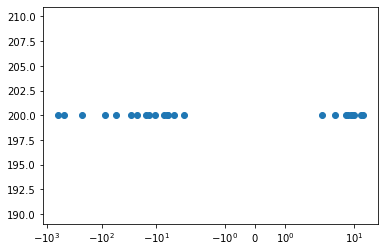

In [160]:
plt.scatter(r['amount'], r['tracer'])
ax = plt.gca()
ax.set_xscale('symlog')

In [ ]:
u = my_data1.plate_map['Protein Name'].unique()
punew = pu[pd.notnull(pu)]
pt = my_data1.plate_map['Tracer Name'].unique()
ptnew = pt[pd.notnull(pt)]

l = len(my_data1.data_dict) * len(punew) * len(ptnew)

In [52]:
my_data2 = FA.read_in_envision(data_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT, platemap_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap, data_type='plate', size=384)
my_data2.background_correct()
my_data2.calculate_r_i(thr=60, plot_i = False)
my_data2.calc_data_to_fit()
my_data2.logistic_fit_all()

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



<ipython-input-43-8fb4bedb4051>:684: RuntimeWarning: The curve fitting failed in the following cases:

[('repeat_1', 'i', ('AtPEX5C WT', 'Lissamine-YQSKL'), RuntimeError('Optimal parameters not found: Number of calls to function has reached maxfev = 1000.'))]

Use the 'logistic_fit_pair' function to adjust the initial guess for the parameters or pass other arguments to the fitting function.
  warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nUse the 'logistic_fit_pair' function to adjust the initial guess for the parameters or pass other arguments to the fitting function.", RuntimeWarning)


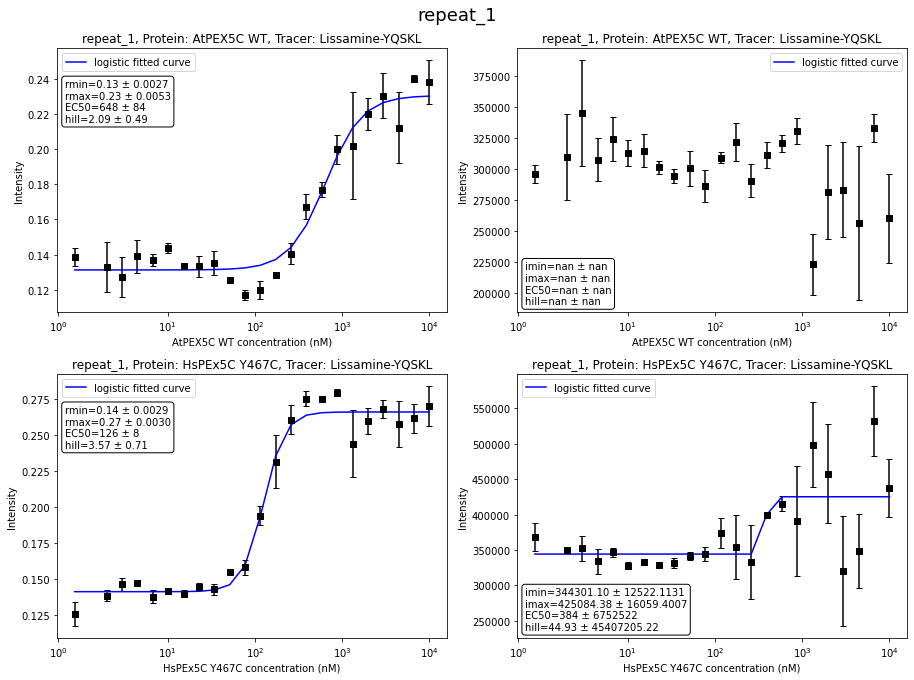

In [53]:
my_data2.plot_ani_all(err='sem')

In [54]:
my_data2.calc_lambda()

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.



Button(description='Save', style=ButtonStyle())

In [55]:
my_data3 = FA.read_in_envision(data_csv=F606C_vs_AtPEX5C_WT_1_hour, platemap_csv=F606C_vs_AtPEX5C_WT_1_hour_platemap, data_type='plate', size=384)
my_data3.background_correct()
my_data3.calculate_r_i(thr=60, plot_i = False)
my_data3.calc_data_to_fit()
my_data3.logistic_fit_all()

Data has been uploaded!

Value of g-factor: 1.0 
Number of repeats: 1 
Overall number of empty cells is 192 in 2 data frames.
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



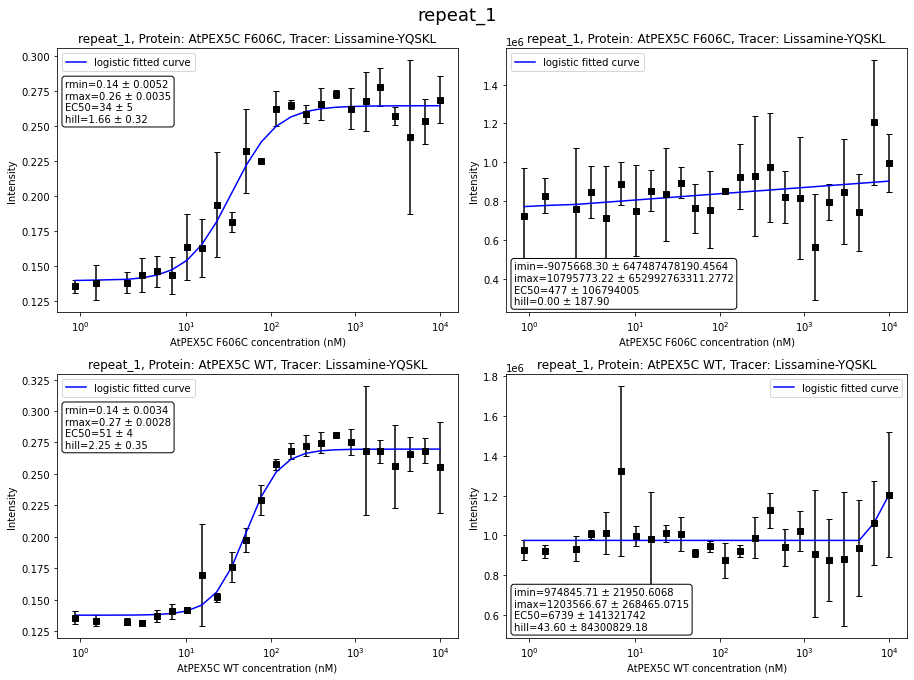

In [57]:
my_data3.plot_ani_all()